In [11]:
%matplotlib inline
import numpy as np
import cPickle
import os
import gzip
from IPython.core.debugger import set_trace
import scipy.optimize
import matplotlib.pyplot as plt

# First exercise: Classifying MNIST with MLPs
In this exercise you will implement a Neural Network (or MLP) and classify the MNIST digits with it.
MNIST is a "well hung" dataset that has been used a lot over the years to benchmark different classification algorithms. 
To learn more about it have a look here: http://yann.lecun.com/exdb/mnist/ .

# Data Loading
We first define a function for downloading and loading MNIST.
**WARNING**: Executing it will obviously use up some space on your machine ;). 

In [37]:
def mnist(datasets_dir='./data'):
    if not os.path.exists(datasets_dir):
        os.mkdir(datasets_dir)
    data_file = os.path.join(datasets_dir, 'mnist.pkl.gz')
    if not os.path.exists(data_file):
        print('... downloading MNIST from the web')
        try:
            import urllib
            urllib.urlretrieve('http://google.com')
        except AttributeError:
            import urllib.request as urllib
        url = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
        urllib.urlretrieve(url, data_file)

    print('... loading data')
    # Load the dataset
    f = gzip.open(data_file, 'rb')
    try:
        train_set, valid_set, test_set = cPickle.load(f, encoding="latin1")
    except TypeError:
        train_set, valid_set, test_set = cPickle.load(f)
    f.close()

    test_x, test_y = test_set
    test_x = test_x.astype('float32')
    test_x = test_x.astype('float32').reshape(test_x.shape[0], 1, 28, 28)
    test_y = test_y.astype('int32')
    valid_x, valid_y = valid_set
    valid_x = valid_x.astype('float32')
    valid_x = valid_x.astype('float32').reshape(valid_x.shape[0], 1, 28, 28)
    valid_y = valid_y.astype('int32')
    train_x, train_y = train_set
    train_x = train_x.astype('float32').reshape(train_x.shape[0], 1, 28, 28)
    train_y = train_y.astype('int32')
    rval = [(train_x, train_y), (valid_x, valid_y), (test_x, test_y)]
    print('... done loading data')
    return rval

# Neural Network Layers
We now define "bare bone" neural network layers.
The parts marked with **TODO** are where you should finish the implementation!
Conceptually we will implement the layers as follows:

Each layer has a constructor ("__init__") that takes an input layer plus some additional arguments such as layer size and the activation function name. The layer then uses the provided input layer to compute the layer dimensions, weight shapes, etc. and setup all auxilliary variables.

Each layer then has to provide three functions (as defined in the Layer class below): *output_shape()*, *fprop()* and *brop()*. The output_shape function is used to figure out the shape for the next layer and the *fprop()/bprop()* functions are used to compute forward and backward passes through the network.

MY comments:
Weights and gradients w,b,dw,db, are Parameters of Layers classes. 
The forward Data flow, Activations (A1, Z1...) are not stored in the classes, but rather flowing through them, as "input" for the fprop() methods. But "last_input" is stored, in order to compute the gradients.
Model is a layer z1,a1,w1,b1,h1() with input layer z0,... and output layer z2,....

Dimensions: n = n_samples, D1, D0, D2 nodes in current, previous, following

In [38]:
# start by defining simple helpers
def sigmoid(x):     # sigmoid to be used for forward pass
    return 1.0/(1.0 + np.exp(-x))

def sigmoid_d(x):   # differential of sigmoid to be used for backward pass (method bprop)
    dx = np.zeros_like(x)  # initialise matrix
    dx = sigmoid(x) * (1.0 - sigmoid(x))    # 1.0+ is broadcasted,  " * "   is element-wise
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_d(x):
    dx = np.zeros_like(x)  # initialise matrix
    dx = 1 - (np.tanh(x))**2  # tanh and sqr elementwise, "1 -" is broadcasted
    return dx        

def relu(x):
    return np.maximum(0.0, x)

def relu_d(x):
    dx = np.zeros_like(x)  # initialise matrix
    dx[x > 0] = 1.         # python stylish elementwise boolean indexing
    return dx     

def softmax(x, axis=1):   # axis = 1: summmiert die Spalten in eine Spalte zusammen (siehe 00-Mystuff)
    # input: output of last layer (=a3, as last layer has no linearity) --> array (n,10), one colon / class/digit
    # softmax applied on each row soft_k e^ak / sum(e^ai) squeezes each row into figures <1, with strong emphasis 
    # on the largest one. Cols sum up to 1 --> can be interpreted as probability distribution among classes 
    # to make the softmax a "safe" operation we will 
    # first subtract the maximum along the specified axis
    # so that np.exp(x) does not blow up!
    # Note that this does not change the output.  # kürzt sich raus 
    x_max = np.max(x, axis=axis, keepdims=True)
    x_safe = x - x_max   
    e_x = np.exp(x_safe)
    # result has same shape as x, but transformed to values between 0 and 1, in each row / sample strong emphasis on largest value
    # np.sum summiert in jeder Zeile die Spalten zusammen (Sum over features)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

# "softmax_d" is not used (only used for output layer, and then gradient together with loss function)

def one_hot(labels):
    """this creates a one hot encoding from a flat vector:
    i.e. given y = [0,2,1]
     it creates y_one_hot = [[1,0,0], [0,0,1], [0,1,0]]
    """
    classes = np.unique(labels)   # how many different elements ([0,3,2,3,2] --> 3)
    n_classes = classes.size
    one_hot_labels = np.zeros(labels.shape + (n_classes,))  # concatenate tuples (3,) and (3,) --> array (3,3) see mystuff
    # set_trace()
    for c in classes:
        one_hot_labels[labels == c, c] = 1
    return one_hot_labels

def unhot(one_hot_labels):
    """ Invert a one hot encoding, creating a flat vector """
    # argmax Returns the indices of the maximum values along an axis.
    return np.argmax(one_hot_labels, axis=-1)   # axis=-1 is last dimension . e.g. =1 if two dim array 

# then define an activation function class, is instantiated when calling (__init__) FullyConnectedLayer
class Activation(object):
    
    def __init__(self, tname):
        if tname == 'sigmoid':
            self.act = sigmoid       # assign appropriate function 
            self.act_d = sigmoid_d
        elif tname == 'tanh':
            self.act = tanh
            self.act_d = tanh_d
        elif tname == 'relu':
            self.act = relu
            self.act_d = relu_d
        else:
            raise ValueError('Invalid activation function.')
                                     # fprop called as subroutine from within layer.fprop()
    def fprop(self, input):          # apply selected activation function on linear input: z1 = h1(a1)
        self.last_input = input      # store a1 for later use in bprop
        return self.act(input)       # h1(a1) call sigmoid, tanh or relu and apply on input 
    
    def bprop(self, output_grad):    # output_grad is dL/dz1, passed by calling method (layer)  (n,D1)
        # set_trace()
        return output_grad * self.act_d(self.last_input)   # dL/da1 = dL/dz1 * h1'(a1) "*" denoting hadamard product

# define a base class for layers - purpose? --> if it does nothing, and everything has to be defined in derived classes ? 
class Layer(object):
    
    def fprop(self, input):   
        """ Calculate layer output for given input 
            (forward propagation). 
        """
        # has to be overloaded by derived class
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def bprop(self, output_grad):
        """ Calculate input gradient and gradient 
            with respect to weights and bias (backpropagation). 
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def output_size(self):
        """ Calculate size of this layer's output.
        input_shape[0] is the number of samples in the input.
        input_shape[1:] is the shape of the feature.
        """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for loss outputs
class Loss(object):

    def loss(self, output, output_net):      # L(y,ŷ)
        """ Calculate mean loss given real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

    def input_grad(self, output, output_net):   # dL(y,ŷ)/dŷ 
        """ Calculate input gradient real output and network output. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a base class for parameterized things        
class Parameterized(object):
    
    def params(self):
        """ Return parameters (by reference) """
        raise NotImplementedError('This is an interface class, please use a derived instance')
    
    def grad_params(self):
        """ Return accumulated gradient with respect to params. """
        raise NotImplementedError('This is an interface class, please use a derived instance')

# define a container for providing input to the network
# represents "Layer" zero, containing Data X, passing to layer 1 without doing anything
class InputLayer(Layer):
    
    def __init__(self, input_shape):        
        if not isinstance(input_shape, tuple):
            raise ValueError("InputLayer requires input_shape as a tuple")
        self.input_shape = input_shape
        # set_trace()

    def output_size(self):
        return self.input_shape
    
    def fprop(self, input):
        return input
    
    def bprop(self, output_grad):
        return output_grad
        
class FullyConnectedLayer(Layer, Parameterized):
    """ A standard fully connected hidden layer, as discussed in the lecture.
    """
    
    def __init__(self, input_layer, num_units, 
                 init_stddev, activation_fun=Activation('relu')):
        self.num_units = num_units                     #4
        self.activation_fun = activation_fun
        self.input_shape = input_layer.output_size()   # tuple with shape of previous layer: z0 = (n,3)
        
        self.W = np.random.standard_normal((self.input_shape[1],self.num_units)) * 0.1    # shape = (3,4)  (num_units_prev, num_units)
        self.b = np.zeros((1,self.num_units))

        self.dW = None
        self.db = None
        

    def output_size(self):     
        return (self.input_shape[0], self.num_units)     # (n,4)
    
    def fprop(self, input):                  # z1 = h1(z0*w1 + b1)   input is z0 (n,D0), output (n,D1)
        self.last_input = input              # store z0 (n,3) for bprop (a1 is stored in activation_fun.last_input)
        # set_trace()
        act = np.dot(input,self.W) + self.b    # a1 = z0*w1 + b1   (n,D1)
        # set_trace()
        assert(act.shape[1] == self.output_size()[1])   # (n,D1) - but n can differ with mini-batches
        if self.activation_fun == None:
            return act             # z1 = a1 = z0*w1 + b1 (n,D1)
        else:
            return self.activation_fun.fprop(act)     # z1 = h1(a1)  (n,D1) 

    # layer.bprop takes output_grad dL/dz1 as argument and returns dL/dz0 as result for passing to next layer 
    # going forward calculates and stores gradients of layer-weights dW1 and db1 based on actual input data
    def bprop(self, output_grad):     # "input gradient" is output_grad: dL/dz1    (n,D1)

        # bprop(dL/dz1)              (n,D1)
        # dL/da1 = dL/dz1 x h'(a1)   (n,D1) (hadamard product)
        # dL/dw1 = z0_T*dL/da1       (D0,D1)
        # dL/db1 = dL/da1            (1,D1)
        # dL/dz0 = dL/da1 * w1_T     (n,D0)        
        # return dL/dz0              (n,D0)

        # ??? HINT: you may have to divide the weights by n
        #       to make gradient checking work 
        #       (since you want to divide the loss by number of inputs)        
        
        
        n = output_grad.shape[0]        
                
        if self.activation_fun == None:
            act_grad = output_grad   # (n,D1) dL/da1 = dL/dz0 - directly passed, assuming h'(a1) = unity matrix
        else:
            # dL/da1 = dL/dz1 x h'(a1)   (n,D1) = (n,D1) x (n,D1) (hadamard product)
            act_grad = self.activation_fun.bprop(output_grad)   # performs hadamard product with a1 which was stored in actvation_fun during fprop()
        
        # dL/dw1 = z0_T*dL/da1       (D0,D1) = (D0,n)*(n,D1)
        self.dW = np.dot(self.last_input.T,act_grad) # dL/dw0 = XT * dL/da0        
        
        # dL/db1 = dL/da0            (1,D1)  collapse from (n,D1) to (1,D1) (to be summed up, after being broadcasted)
        self.db = act_grad.sum(axis=0, keepdims=True)
                         
        # dL/dz0 = dL/da1 * w1_T     (n,D0) = (n,D1)*(D1,D0)  
        grad_input = np.dot(act_grad,self.W.T)   # ?? n*

        return grad_input     # must have same shape as "last input" (n,D0)
        
    def params(self):      
        return self.W, self.b    # returns handles / "pointers"

    def grad_params(self):
        return self.dW, self.db

# finally we specify the interface for output layers 
# which are layers that also have a loss function
# we will implement two output layers:
# a Linear, and Softmax (Logistic Regression) layer
# The difference between output layers and and normal 
# layers is that they will be called to compute the gradient
# of the loss through input_grad(). bprop will never 
# be called on them!
class LinearOutput(Layer, Loss):   # inherits from classes Layer and Loss
    """ A simple linear output layer that  
        uses a squared loss (e.g. should be used for regression)
    """
    def __init__(self, input_layer):        # is called with "layer[-1]", passing last preceding layer as "input_layer"
        self.input_size = input_layer.output_size()
        
    def output_size(self):    # return scalar (loss/error)
        return (1,)
        
    def fprop(self, input):   # get ŷ from upper layer, pass to loss function
        return input

    def bprop(self, output_grad):
        raise NotImplementedError(
            'LinearOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):            # returns dL/da3 - same dim as Y, Y_pred (n,Dlast)
        # set_trace()
        # n_samples = float(Y.shape[0])
        n_samples = Y.shape[0]

        loss_d = (Y_pred - Y) / n_samples        # gradient of squared loss, see summer course squared_error_grad, /n_samples because each sample contributes only marginal to total loss ?? 
        # loss_d = (Y - Y_pred)        # gradient of squared loss, see summer course squared_error_grad, /n_samples because each sample contributes only marginal to total loss ?? 

        return loss_d

        # return np.sqrt(np.sum(0.5 * loss_d**2, axis=1))
        # return np.mean(np.sum(loss_d, axis=1))  # sum over features / mean over samples

    # given in code stub
    def loss(self, Y, Y_pred):                   # matrix (n,d_out) 
        loss = 0.5 * np.square(Y - Y_pred)       # element-wise 0.5
        return np.mean(np.sum(loss, axis=1))     # sum of squares over out_put nodes / features, then mean over n samples

        # return np.mean(0.5 * (y_predicted - y)**2) summer course, here y only one dim   
    
    
class SoftmaxOutput(Layer, Loss):
    """ A softmax output layer that calculates 
        the negative log likelihood as loss
        and should be used for classification.
    """
    
    def __init__(self, input_layer):
        self.input_size = input_layer.output_size()
        
    def output_size(self):
        return (1,)
    
    def fprop(self, input):
        return softmax(input)
    
    def bprop(self, output_grad):
        raise NotImplementedError(
            'SoftmaxOutput should only be used as the last layer of a Network'
            + ' bprop() should thus never be called on it!'
        )
    
    def input_grad(self, Y, Y_pred):    # y_pred is Ŷ / f(x) is output of last layer = a3 = z3 (no nonlinearity in last layer)
        n_samples = Y.shape[0]

        loss_d = (Y_pred - Y) / n_samples        # gradient of squared loss, see summer course squared_error_grad, 
        
        # compute dL/da3 = dL/dŶ * dŶ/da3 = softmax(a3) - y via mathematical shortcut
        # same calculation as for sigmoid combined with cross entropy (see paper back-prop cross entropy.pdf)
        # n_samples = Y.shape[0]
        # result = (Y_pred - Y) / n_samples    # y is one hot encoded
        # result = softmax(Y_pred) - Y       # y is one hot encoded
        return loss_d                 # shape (n,Dlast) --> passed to last layer, for further backprop
        # 
        # TODO #######################################################
        # TODO: implement gradient of the negative log likelihood loss
        # TODO #######################################################
        # HINT: since this would involve taking the log 
        #       of the softmax (which is np.exp(x)/np.sum(x, axis=1))   --> ?? rather np.exp(x)/np.sum(np.exp(x), axis=1))
        #       this gradient computation can be simplified a lot! 
        # return np.zeros_like(Y_pred)
        # further test modification

    def loss(self, Y, Y_pred):               # Y is one hot encoded, Y_pred is output of softmax, called by fprop, called by predict before calling _loss()
        # Y (n,10) for each row y is e.g. [0,0,0,1,0,0,0,0,0,0], 
        # Y_pred (n,10) is output of last layer, e.g. [2, 37, 3, 12, 3, 1, 2, 3, ...] 
        # out = softmax(Y_pred)   !! bug             # vector (n_out)
        # out = Y_pred
        # out (n,10) is e.g. [0.01, 0.01, 0.01, 0.7, 0.1,....], representing probability distribution over 10 classes
        
        product = Y * Y_pred           # elementwise prod --> zero for all columns, exept for one, where Y=1

        loss = np.sum(product,axis=1)  # (n,) collapsing colums into one column --> one loss per row
        
        # to make the loss numerically stable 
        # you may want to add an epsilon in the log ;) loss could be zero, --> log explodes
        eps = 1e-10

        cross_entropy = - np.log(loss + eps)   # (n,)

        return np.mean(cross_entropy)          # (1,), scalar

# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [47]:
class NeuralNetwork:
    """ Our Neural Network container class. # 
    """
    def __init__(self, layers):    # https://www.python-course.eu/python3_magic_methods.php __init is called automatically, here the method is overloaded
        self.layers = layers
        
    def _loss(self, X, Y):    # single underscore used by convention to avoid conflicts with python keywords
        Y_pred = self.predict(X)    # yields output of softmax
        return self.layers[-1].loss(Y, Y_pred)    # loss function of last layer

    def predict(self, X):    # forward pass through all layers, return Y_pred (Ŷ)   
        """ Calculate an output Y for the given input X. """
        # print("predict\n")
        next_output = X
        # set_trace()
        for l, layer in enumerate(self.layers):
            next_output = layer.fprop(next_output)    # z1 = layer.fprop(z0)
            # print("predict layer {} next_output \n{} \n".format(l,next_output))
        Y_pred = next_output
        return Y_pred         # (n,10), as returned by softmax --> to be interpreted as one hot encoded
    # ???? next_grad OK ?? überlebt for schleife ? 
    def backpropagate(self, Y, Y_pred, upto=0):    # updating all W,b params 
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        # backpropagate through all layers, start with last layer, there call input_grad() instead of bprop
        next_grad = self.layers[-1].input_grad(Y, Y_pred)   # returns "input_grad" dL/da3 of upper fully connected layer
        # set_trace()
        # print("backprop input_output \n{} \n".format(next_grad))
        for layer in reversed(self.layers[upto:-1]):    # run backwards, from the second last down to "upto"
            next_grad = layer.bprop(next_grad) 
            # print("backprop next_output \n{} \n".format(next_grad))

        # print("backprop final output \n{} \n".format(next_grad))
            
        return next_grad       # return gradient of last layer, dL/dX (n,D)
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))     # convert softmax output vector --> digit 
        error = Y_pred != Y
        return np.mean(error)   # error rate

     
    def update_network(self, learning_rate):        # update all parameters given current gradients
        for lc, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):     # only parameterized layers, not input and output_layer
                # set_trace()
                layer.W = layer.W - layer.dW * learning_rate
                layer.b = layer.b - layer.db * learning_rate

                # W,b   = layer.params()
                # dW,db = layer.grad_params()
                # print("layer_before {} W \n {}".format(lc,W))
                # W = W - dW * learning_rate           # W,b are pointers, assignment "W =" acts NOT on object variable (tested)
                # b = b - db * learning_rate
                # set_trace()
                # print("layer_after {} W \n {}".format(lc,W))
                # layer.W = W
                # layer.b = b
                # print("layer_changed {} W \n {}".format(lc,W))
                

                
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size      # define the number of mini batches
        for b in range(n_batches):
            batch_start = b * batch_size
            batch_end = (b + 1) * batch_size
            
            X_batch = X[batch_start:batch_end]
            Y_batch = Y[batch_start:batch_end]   # if batch_end too large --> gets ignored by numpy  
            
            Y_batch_pred = self.predict(X_batch)
            
            self.backpropagate(Y_batch, Y_batch_pred)
            
            self.update_network(learning_rate)
            
            # TODO #####################################
            # Implement stochastic gradient descent here
            # TODO #####################################
            # start by extracting a batch from X and Y
            # (you can assume the inputs are already shuffled)

            # TODO: then forward and backward propagation + updates
            # HINT: layer.params() returns parameters *by reference*
            #       so you can easily update in-place
            # pass   
    
    def gd_epoch(self, X, Y, learning_rate):       # ? why no learning rate here ?
        # first attempt: whole dataset
        Y_pred = self.predict(X)         # predict Y based on given data and presend parameter settings
        # print("predict {}\n".format(Y_pred))
        self.backpropagate(Y, Y_pred)    # comparing Y and Y_pred calculate gradients of all parameters (stored in layers)

        # update all parameters of all layers
        self.update_network(learning_rate)
        
        # TODO ##################################################
        # Implement batch gradient descent here
        # A few hints:
        #   There are two strategies you can follow:
        #   Either shove the whole dataset throught the network
        #   at once (which can be problematic for large datasets)
        #   or run through it batch wise as in the sgd approach
        #   and accumulate the gradients for all parameters as
        #   you go through the data. Either way you should then
        #   do one gradient step after you went through the
        #   complete dataset!
        # TODO ##################################################
        # pass

#   def validation_error(self, X_valid, _valid):
#        """ Train network on the given data. """
#        global y_valid, X_valid
#        n_samples = X.shape[0]                      
        
        
    def train(self, X, Y, X_val=[], Y_val=[], learning_rate=0.1, max_epochs=100, 
              batch_size=64, descent_type="sgd", y_one_hot=True):
        """ Train network on the given data. """
        n_samples = X.shape[0]              
        n_batches = n_samples // batch_size
        if y_one_hot:           # !! y_one_hot = False yields error, because self.predict always un_hots 
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)             # calls one forward pass given X and computes loss on result
            train_error = self.classification_error(X, Y)   # calls one forward pass given X and counts error-rate (in % of all data)

            # valid_loss = self._loss(X_valid, Y_train)     #
            if len(X_val) > 0:
                valid_error = self.classification_error(X_val, Y_val)   # 
                # print('epoch {:.4f}, validation error {:.4f}'.format(e, valid_error))

                print('epoch {:.4f}, loss {:.4f}, train error {:.4f}, valid error {:.4f}'.\
                      format(e, train_loss, train_error, valid_error))            
            else:
                print('epoch {:.4f}, loss {:.4f}, train error {:.4f}'.\
                      format(e, train_loss, train_error))            
            
            
    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):      # not for layers without parameters (input / output)
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):    # layer.params() returns layer.W and layer.b (p=tuple(2,))
                    # we iterate through all parameters, first W then b
                    param_shape = param.shape

                    def output_given_params(param_new):  # return output / loss of total network given new params
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # assign new params to param of this layer, referenced by param[:]
                        param[:] = np.reshape(param_new, param_shape)    # 
                        # return loss, computed with these new params
                        return self._loss(X, Y)

                    def grad_given_params(param_new):     # return grad of this param (W or b) given the param
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # assign new param W or b to this layer, referenced by param[:]
                        param[:] = np.reshape(param_new, param_shape)
                        
                        Y_pred = self.predict(X)               # prediction based on new params, softmax output vector (n,10)
                        # backpropagate given new Y_pred, update all gradients dW, db up to this layer 
                        # set_trace()
                        self.backpropagate(Y, Y_pred, upto=l)  # Backpropagation of partial derivatives 
                        # return the computed gradient W or b of this layer
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))
                    # set_trace()

                    epsilon = 1e-4
                    # sci_err = scipy.optimize.check_grad(output_given_params, grad_given_params, param_init, epsilon=epsilon)
                    # print('scipy_grad_error {:.2e} \n'.format(sci_err))                    
                    
                    loss_base = output_given_params(param_init)    # scalar loss at current params
                    # set_trace()

                    # for each single element of W,b make eps step and calculate finite difference
                    gparam_fd = np.zeros_like(param_init)    # gradient calculated through finited differences
                    new_param = np.zeros_like(param_init)    # new, eps-deviated param for testing
                    for i in range(param_init.shape[0]):     # go through all rows and colums of this W or b 
                        # for j in range(param.shape[1]):
                        new_param[:] = param_init            # set back to orignial value

                        new_param[i] = param_init[i] + epsilon    # vary only for this element
                        loss_plus = output_given_params(new_param)           

#                        new_param[i] = param_init[i] - epsilon
#                        loss_minus = output_given_params(new_param)
                            
                        gparam_fd[i] = (loss_plus - loss_base) / (epsilon)   # dfferential --> approximated gradient                            
                    
                    gparam_bprop = grad_given_params(param_init)  # gradient als calculated by bprop
                    # print("gparam_bprop {}\n".format(gparam_bprop))
                    # print("gparam_fd {}\n".format(gparam_fd))
                    # print("diff {}\n".format(gparam_bprop/gparam_fd))


                    # err = np.mean(np.abs(gparam_bprop - gparam_fd))   Scipi grad check takes L2 error
                    # set_trace()
                    err = np.sqrt(np.sum((gparam_bprop - gparam_fd)**2))  # as SciPi 
                    print('grad_error {:.2e}'.format(err))
                    # if err > epsilon:
                        # print("error too large")
                    # assert(err < epsilon)
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

In [140]:
# first super-mini network for preliminary tests
X = np.array([[1.,2.,3.],[2.,5.,3.],[2.,4.,6.],[1.,2.,3.]])   
y = np.array([1,2,0,1])

mini_layers = [InputLayer(X.shape)]
mini_layers.append(FullyConnectedLayer(
                mini_layers[-1],      
                num_units=5,    
                init_stddev=0.1,
                activation_fun=Activation('relu')
                # activation_fun = None    
))
mini_layers.append(FullyConnectedLayer(
                mini_layers[-1],      
                num_units=2,    
                init_stddev=0.1,
                activation_fun=Activation('sigmoid')
                # activation_fun = None    
))
mini_layers.append(FullyConnectedLayer(
                mini_layers[-1],      
                num_units=3,    # number of classes = number of different digits in y
                init_stddev=0.1,
                # activation_fun=Activation('relu')
                activation_fun = None    
))
mini_layers.append(SoftmaxOutput(mini_layers[-1]))
# mini_layers.append(LinearOutput(mini_layers[-1]))

nn_mini = NeuralNetwork(mini_layers)
y_one_hot = one_hot(y)
print(y_one_hot)
#nn_mini.check_gradients(X, y_one_hot)
nn_mini.train(X, y, learning_rate=0.1, 
              max_epochs=3, batch_size=2, descent_type="sgd", y_one_hot=True)

[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  1.  0.]]
... starting training
epoch 0.0000, loss 1.0965, train error 0.7500
epoch 1.0000, loss 1.0853, train error 0.5000
epoch 2.0000, loss 1.0763, train error 0.5000
epoch 3.0000, loss 1.0689, train error 0.5000


# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [49]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],      
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [50]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [51]:
nn.check_gradients(X, Y)

checking gradient for layer 1
grad_error 2.53e-07
grad_error 3.86e-08
checking gradient for layer 2
grad_error 3.22e-07
grad_error 5.00e-07
checking gradient for layer 3
grad_error 1.79e-07
grad_error 8.21e-06


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

First load the data and reshape it.

In [52]:
# load
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
X_test,  y_test  = Dtest
# Downsample training data to make it a bit faster for testing this code
n_train_samples = 100000
n_valid_samples = 100000
n_test_samples = 100000

train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

valid_idxs = np.random.permutation(X_valid.shape[0])[:n_valid_samples]
X_valid = X_valid[valid_idxs]
y_valid = y_valid[valid_idxs]

test_idxs = np.random.permutation(X_test.shape[0])[:n_test_samples]
X_test = X_test[test_idxs]
y_test = y_test[test_idxs]

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [53]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

print("y_valid shape: {}".format(np.shape(y_valid)))
print("y_test shape: {}".format(np.shape(y_test)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)
y_valid shape: (10000,)
y_test shape: (10000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [54]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

Reshaped X_train size: (50000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [132]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=200,
                init_stddev=0.01,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=200,
                init_stddev=0.01,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=200,
                init_stddev=0.01,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,        # last layer has 10 units, one for each figure --> one hot encoding
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.4, 
         max_epochs=20, batch_size=60, descent_type="sgd", y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

... starting training
epoch 0.0000, loss 0.1138, train error 0.0353, valid error 0.0378
epoch 1.0000, loss 0.0714, train error 0.0227, valid error 0.0327
epoch 2.0000, loss 0.0438, train error 0.0143, valid error 0.0273
epoch 3.0000, loss 0.0294, train error 0.0095, valid error 0.0240
epoch 4.0000, loss 0.0194, train error 0.0059, valid error 0.0219
epoch 5.0000, loss 0.0171, train error 0.0057, valid error 0.0243
epoch 6.0000, loss 0.0084, train error 0.0024, valid error 0.0228
epoch 7.0000, loss 0.0055, train error 0.0014, valid error 0.0237
epoch 8.0000, loss 0.0031, train error 0.0007, valid error 0.0206
epoch 9.0000, loss 0.0022, train error 0.0004, valid error 0.0213
epoch 10.0000, loss 0.0013, train error 0.0001, valid error 0.0209
epoch 11.0000, loss 0.0008, train error 0.0001, valid error 0.0201
epoch 12.0000, loss 0.0007, train error 0.0000, valid error 0.0201
epoch 13.0000, loss 0.0006, train error 0.0000, valid error 0.0203
epoch 14.0000, loss 0.0005, train error 0.0000, va

In [134]:
# Test Error
test_err = nn.classification_error(X_test,y_test)
print("Test Error: {}".format(test_err))

Test Error: 0.0205


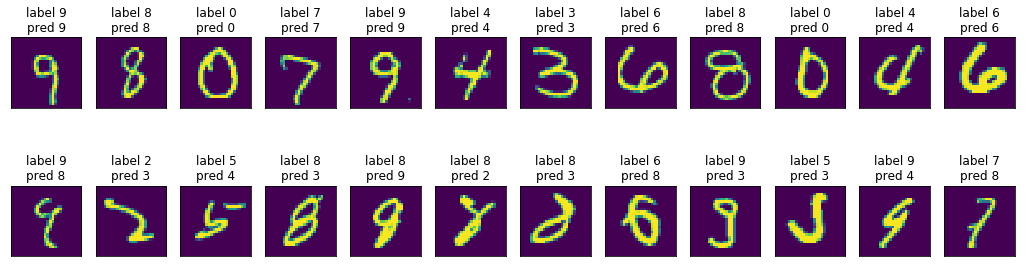

In [137]:
start = 24        # starting point in Lists of Images to be displayed
n_images = 12     # number of images

y_valid_pred = unhot(nn.predict(X_valid))

# print("y_valid_pred \n{}".format(y_valid_pred[:20]))
# print("y_valid \n{}".format(y_valid[:20]))

X_True =  X_valid[y_valid == y_valid_pred]
L_True =  y_valid[y_valid == y_valid_pred]
L_True_pred = y_valid_pred[y_valid == y_valid_pred]

X_False = X_valid[y_valid != y_valid_pred]
L_False = y_valid[y_valid != y_valid_pred]
L_False_pred = y_valid_pred[y_valid != y_valid_pred]

True_images = X_True[start:n_images+start][:].reshape(n_images,28,28)
True_Labels = L_True[start:n_images+start]
True_Labels_pred = L_True_pred[start:n_images+start]
False_images = X_False[start:n_images+start][:].reshape(n_images,28,28)
False_Labels = L_False[start:n_images+start]
False_Labels_pred = L_False_pred[start:n_images+start]

fig, axes = plt.subplots(2, n_images, squeeze=False, figsize=(18,5))
axes[0][0].set_title('True positives')

for i in range(n_images):
        axes[0][i].imshow(True_images[i], interpolation='nearest')
        axes[0][i].set_title('label ' + str(True_Labels[i])+ '\n' + 'pred ' + str(True_Labels_pred[i]))
        axes[0][i].grid(False)
        axes[0][i].set_xticks([])
        axes[0][i].set_yticks([])   
        
for i in range(n_images):
        axes[1][i].imshow(False_images[i], interpolation='nearest')
        axes[1][i].set_title('label ' + str(False_Labels[i])+ '\n' + 'pred ' + str(False_Labels_pred[i]))        
        axes[1][i].grid(False)
        axes[1][i].set_xticks([])
        axes[1][i].set_yticks([]) 

# Figure out a reasonable Network that achieves good performance
As the last part of this task, setup a network that works well and gets reasonable accuracy, say ~ 1-3 percent error on the **validation set**. 
Train this network on the complete data and compute the **test error**. 

Once you have done this, visualize a few digits from the the test set that the network gets right as well as a few that the network gets wrong!